# Lab 6.5.2: Ridge Regression and the Lasso

## Attribution

Orignal notebook by Emre Can ([source](https://github.com/emredjan/ISL-python/blob/master/labs/lab_06.6_ridge_regression_and_the_lasso.ipynb)). Updated to ISLRv2 by Daniel Kapitan (30-01-2022).


## Introduction
We will use `Ridge`, `RidgeCV`, `Lasso` and `LassoCV` from `sklearn.linear_model` to perform ridge regression and the lasso. We will do this in order to predict `Salary` on the `Hitters` data. We have already removed missing values upon loading the data from csv, but still need to transform qualitative variables into dummy variables. The latter is important because `sklearn` can only take numerical, quantitative inputs.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

%matplotlib inline
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 12)
pd.set_option("display.float_format", "{:20,.5f}".format)

hitters = pd.read_csv("../datasets/Hitters.csv", index_col=0).dropna()
hitters.index.name = "Player"

X = hitters.drop(columns=['Salary'])
y = hitters.Salary
for col in ['League', 'Division', 'NewLeague']:
        X[col] = pd.get_dummies(X[col]).iloc[:, 1]

## Ridge Regression

In `sklearn` the regularization parameter $\lambda$ is named `alpha`, as is the case for the `Ridge` and `RidgeCV` classes. We choose to implement the function over a grid of values ranging from $\lambda = 10^{10}$ to $\lambda = 10^{-2}$, essentially covering the full range of scenarios from the null model containing only the intercept, to the least squares fit. As we will see, we can also compute model fits for a particular $\lambda$ that is not one of the original `grid` values. Note that `sklearn.linear_model` does not standardize by default. To this purpose, we recommend to use `StandardScaler` as a preprocessing step in a `Pipeline` object.

Associated with each value of $\lambda$ is a vector of ridge regression coefficients, stored in a matrix that can be accessed with the `coef_` attribute. Because we are using a `Pipeline`, we need to specify the named step in the pipeline for which we want to access an attribute.

In [2]:
grid = 10 ** np.linspace(10, -2, 100)
ridge_model = make_pipeline(StandardScaler(with_mean=False), Ridge())
models = {}

for i, a in enumerate(grid):
    ridge_model.set_params(ridge__alpha=a)
    ridge_model.fit(X, y)
    models[i] = {"alpha": a,
        "coefs": ridge_model.named_steps["ridge"].coef_,
        "intercept": ridge_model.named_steps["ridge"].intercept_,
    }

In [3]:
models[49]

{'alpha': 11497.569953977356,
 'coefs': array([ 3.49457396,  3.95273518,  2.98390005,  3.75468987,  3.9810762 ,
         3.99185664,  3.46120924,  4.61714183,  4.84825026,  4.62598752,
         4.9699381 ,  5.0089575 ,  4.27552715, -0.03422276, -1.87780156,
         2.83798607,  0.23644179, -0.06961642,  0.04848929]),
 'intercept': 453.41464799826485}

In [4]:
print(f"Number of models: {len(models)}")
print(f"Number of coefficients per model: {len(models[0]['coefs'])}")

Number of models: 100
Number of coefficients per model: 19


We expect the coefficient estimates to be much smaller, in terms of $l_2$ norm, when a large value of $\lambda$ is used, as compared to when a small value of $\lambda$ is used. These are the coefficients when $\lambda = 11,498$, along with their $L_2$ norm:

In [5]:
def print_ridge_results(i):
    print(f"alpha: {models[i]['alpha']}")
    print(f"intercept: {models[i]['intercept']}")
    print(pd.Series(models[i]['coefs'], index=X.columns))
    print(f"L2: {np.sqrt(np.sum([x**2 for x in models[i]['coefs'] ]))}")

print_ridge_results(49)

alpha: 11497.569953977356
intercept: 453.41464799826485
AtBat                    3.49457
Hits                     3.95274
HmRun                    2.98390
Runs                     3.75469
RBI                      3.98108
Walks                    3.99186
Years                    3.46121
CAtBat                   4.61714
CHits                    4.84825
CHmRun                   4.62599
CRuns                    4.96994
CRBI                     5.00896
CWalks                   4.27553
League                  -0.03422
Division                -1.87780
PutOuts                  2.83799
Assists                  0.23644
Errors                  -0.06962
NewLeague                0.04849
dtype: float64
L2: 15.509329901628673


In contrast, here are the coefficients when $\lambda = 705$, along with their $l_2$ norm. Note the much larger $l_2$ norm of the coefficients associated with this smaller value of $\lambda$.

In [6]:
print_ridge_results(59)

alpha: 705.4802310718645
intercept: 106.26999409130383
AtBat                   16.43691
Hits                    24.14789
HmRun                   11.54152
Runs                    20.79688
RBI                     19.99724
Walks                   23.88545
Years                   13.47874
CAtBat                  22.48210
CHits                   25.85029
CHmRun                  23.99095
CRuns                   26.45447
CRBI                    26.81973
CWalks                  18.86201
League                   4.29467
Division               -19.59863
PutOuts                 24.64957
Assists                  1.67757
Errors                  -2.60291
NewLeague                3.19072
dtype: float64
L2: 84.41074083895579


We now split the samples into a training set and a test set in order to estimate the test eroor of ridge regression and the lasso. There are various ways to randomly split a data set. The first is to produce a random vector of `True`, `False` elements and select the observations corresponding to `True` for the training data. The second is to randomly choose a subset of numbers between 1 and $n$; these can then be used as the indices for the training observations. Another way is to use the `train_test_split` function from `sklearn`, which we demonstrate here.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

Next we fit a ridge regression model on the training set, and evaluate its MSE on the test set, using $\lambda = 4$.

In [8]:
ridge2 = make_pipeline(StandardScaler(with_mean=False), Ridge(alpha=4))
ridge2_fit = ridge2.fit(X_train, y_train)
y_pred2 = ridge2.predict(X_test)

print(pd.Series(ridge2_fit.named_steps["ridge"].coef_, index=X.columns))
print("MSE:", mean_squared_error(y_test, y_pred2))

AtBat                 -210.80732
Hits                   193.07693
HmRun                  -51.43737
Runs                     1.62407
RBI                     81.45892
Walks                   94.58254
Years                  -28.02948
CAtBat                -117.92436
CHits                   91.15963
CHmRun                  91.76201
CRuns                  101.11545
CRBI                   117.59896
CWalks                 -38.43468
League                  35.79205
Division               -60.24544
PutOuts                125.55607
Assists                 25.55919
Errors                 -18.51890
NewLeague              -18.65062
dtype: float64
MSE: 102144.52395076495


The test MSE is 102,144. Note that if we had instead simply fit a model with just an intercept, we would have predicted each test observation using the mean of the training observations. In that case, we could compute the test set MSE like this:

In [9]:
np.mean((np.mean(y_train) - y_test)**2)

172862.23592080918

We could also get the same result by fitting a ridge regression model with a _very_ large value of $\lambda$. Note that `1e10` means $10^{10}$.

In [10]:
# very high lambda
ridge3 = make_pipeline(StandardScaler(with_mean=False), Ridge(alpha=1e10))
ridge3_fit = ridge3.fit(X_train, y_train)
y_pred3 = ridge3.predict(X_test)

print(pd.Series(ridge3_fit.named_steps["ridge"].coef_, index=X.columns))
print("MSE:", mean_squared_error(y_test, y_pred3))

AtBat                    0.00000
Hits                     0.00000
HmRun                    0.00000
Runs                     0.00000
RBI                      0.00000
Walks                    0.00000
Years                    0.00000
CAtBat                   0.00000
CHits                    0.00000
CHmRun                   0.00000
CRuns                    0.00000
CRBI                     0.00000
CWalks                   0.00000
League                  -0.00000
Division                -0.00000
PutOuts                  0.00000
Assists                 -0.00000
Errors                   0.00000
NewLeague               -0.00000
dtype: float64
MSE: 172862.22059245987


So fitting a ridge regression model with $\lambda = 4$ leads to a much lower test MSE than fitting a model with just an intercept. We now check whether there is any benefit to performing ridge regresion with $\lambda = 4$ instead of just performing least squares regression. Recall that least squares is simply ridge regression with $\lambda = 0$.

In [11]:
ridge4 = make_pipeline(StandardScaler(with_mean=False), Ridge(alpha=0))
ridge4_fit = ridge4.fit(X_train, y_train)
y_pred4 = ridge4.predict(X_test)

print(pd.Series(ridge4_fit.named_steps["ridge"].coef_, index=X.columns))
print("MSE:", mean_squared_error(y_test, y_pred4))

AtBat                 -266.55305
Hits                   197.70622
HmRun                  -38.10318
Runs                    -1.00800
RBI                    103.11985
Walks                   79.75021
Years                   45.35770
CAtBat              -1,399.81138
CHits                1,426.95481
CHmRun                 264.03798
CRuns                   86.85878
CRBI                  -211.14239
CWalks                  42.53360
League                  66.82285
Division               -56.87028
PutOuts                126.07556
Assists                 65.81609
Errors                 -38.31389
NewLeague              -40.96269
dtype: float64
MSE: 116690.4685666027


In general, instead of arbitrarily choosing $\lambda = 4$, it would be better to use cross-validation to choose the tuning parameter $\lambda$. We can do this using the built-in cross-validation function `RidgeCV`. By default, the function performs ten-fold cross-validation, though this can be changed using the argument `cv`.

In [12]:
ridge_cv = make_pipeline(
    StandardScaler(with_mean=False),
    RidgeCV(alphas=grid, scoring="neg_mean_squared_error"),
)
ridge_cv.fit(X_train, y_train)
ridge_cv.named_steps["ridgecv"].alpha_

75.64633275546291

Therefore, we see that the value of $\lambda$ that results in the smallest cross-validation error is 75.6. What is the test MSE associated with this value of $\lambda$?

In [13]:
# cv_lambda
ridge5 = make_pipeline(
    StandardScaler(with_mean=False), Ridge(alpha=ridge_cv.named_steps["ridgecv"].alpha_)
)
ridge5_fit = ridge5.fit(X_train, y_train)
y_pred5 = ridge5.predict(X_test)

print(pd.Series(ridge5_fit.named_steps["ridge"].coef_, index=X.columns))
print("MSE:", mean_squared_error(y_test, y_pred5))

AtBat                   -1.87522
Hits                    40.04216
HmRun                   -2.25864
Runs                    18.79162
RBI                     34.08055
Walks                   48.03307
Years                    5.77862
CAtBat                  15.43406
CHits                   34.10274
CHmRun                  45.40307
CRuns                   34.78448
CRBI                    45.19872
CWalks                  24.57958
League                   9.43059
Division               -46.01926
PutOuts                 83.78692
Assists                 -2.44659
Errors                  -1.98723
NewLeague                4.97471
dtype: float64
MSE: 99820.74305168974


This represents a further improvement over the test MSE that we got using $\lambda = 4$. As expected, none of the coefficients are zero - ridge regression does not perform variable selection!

## The Lasso

We saw that ridge regression with a wise choice of $\lambda$ can outperform least squares as well as the null model on the `Hitters` data set. We now ask whether the lasso can yield either a more accurate or a more interpretable model than ridge regression. In order to fit a lasso model, we use `Lasso` from `sklearn`. Other than that change, we proceed just as we dit in fitting a ridge model

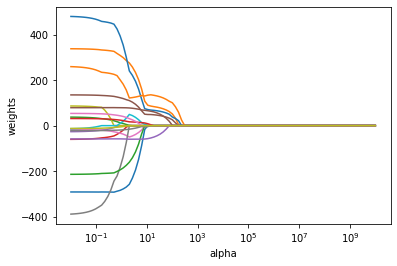

In [14]:
lasso_model = make_pipeline(StandardScaler(with_mean=False), Lasso(max_iter=10_000))
lassos = {}
for i, a in enumerate(grid):
    lasso_model.set_params(lasso__alpha=a)
    lasso_model.fit(X, y)
    lassos[i] = {
        "alpha": a,
        "coefs": lasso_model.named_steps["lasso"].coef_,
        "intercept": lasso_model.named_steps["lasso"].intercept_,
    }
    
ax = plt.gca()
ax.plot(grid, [x['coefs'] for x in lassos.values()] )
ax.set_xscale("log")
plt.axis("tight")
plt.xlabel("alpha")
plt.ylabel("weights");

We can see from the coefficient plot that depending on the choice of tuning parameter, some of the coefficients will be exactly equal to zero. We now perform cross-validation and compute the associated test error.

In [15]:
lasso_cv = make_pipeline(
    StandardScaler(with_mean=False),
    LassoCV(alphas=grid, max_iter=10_000, cv=10),
)
lasso_cv.fit(X_train, y_train)
lasso_cv.named_steps["lassocv"].alpha_

24.77076355991714

In [16]:
lasso2 = lasso_model = make_pipeline(
    StandardScaler(with_mean=False),
    Lasso(alpha=lasso_cv.named_steps["lassocv"].alpha_, max_iter=10_000),
)
lasso2_fit = lasso2.fit(X_train, y_train)
y_pred2 = lasso2_fit.predict(X_test)

print(pd.Series(lasso2_fit.named_steps['lasso'].coef_, index=X.columns))
print("MSE:", mean_squared_error(y_test, y_pred2))

AtBat                    0.00000
Hits                    51.23005
HmRun                    0.00000
Runs                     0.00000
RBI                      0.00000
Walks                   67.81051
Years                    0.00000
CAtBat                   0.00000
CHits                    0.00000
CHmRun                  20.50906
CRuns                    0.00000
CRBI                   182.42795
CWalks                   0.00000
League                   0.00000
Division               -47.16690
PutOuts                111.64058
Assists                 -0.00000
Errors                  -0.00000
NewLeague                0.00000
dtype: float64
MSE: 104808.76054941256


This is substantially lower that the test set MSE of the null model and of least squares, and very similar to the test MSE of ridge regression with $\lambda$ chosen by cross-validation.

However, the lasso has a substantial advantage of ridge regression in that the resulting coefficients estimates are sparse. Here we see that 13 of the 19 coefficient estimates are exactly zero. So the lasso model with $\lambda$ chosen by cross-validation contrains only 6 variables.